In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)
print len(storage.samples)

11
19


In [3]:
retis = storage.transitions.load(0)
print retis

In [4]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 1.24 s, sys: 191 ms, total: 1.43 s
Wall time: 1.4 s


In [6]:
retis.histograms

{'max_lambda': {<openpathsampling.ensemble.SequentialEnsemble at 0x1066d9990>: <openpathsampling.analysis.histogram.Histogram at 0x1105c0b10>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x11059b250>: <openpathsampling.analysis.histogram.Histogram at 0x110bec090>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1105a6450>: <openpathsampling.analysis.histogram.Histogram at 0x110c2e390>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1105a7b10>: <openpathsampling.analysis.histogram.Histogram at 0x110bdd850>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1105bb450>: <openpathsampling.analysis.histogram.Histogram at 0x1105b2390>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x1105c9b90>: <openpathsampling.analysis.histogram.Histogram at 0x110c44290>},
 'pathlength': {<openpathsampling.ensemble.SequentialEnsemble at 0x1066d9990>: <openpathsampling.analysis.histogram.Histogram at 0x1105c0b90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x11059b250>: <op

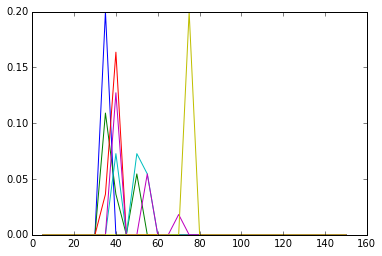

In [7]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

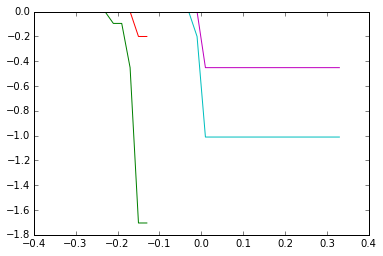

In [8]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

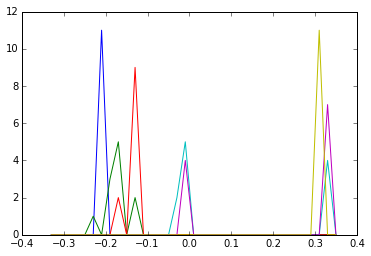

In [9]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

In [11]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

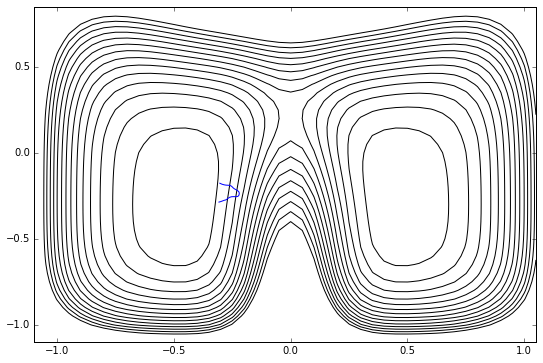

In [13]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,10)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [14]:
from openpathsampling.analysis.histogram import histograms_to_pandas_dataframe
df = histograms_to_pandas_dataframe(retis.histograms['max_lambda'].values(), fcn="reverse_cumulative").sort(axis=1)
df

,max_lambda A->B I'face 0,max_lambda A->B I'face 1,max_lambda A->B I'face 2,max_lambda A->B I'face 3,max_lambda A->B I'face 4,max_lambda A->B I'face 5
-0.33,1,1.000000,1.000000,1.000000,1.000000,1
-0.31,1,1.000000,1.000000,1.000000,1.000000,1
-0.29,1,1.000000,1.000000,1.000000,1.000000,1
-0.27,1,1.000000,1.000000,1.000000,1.000000,1
-0.25,1,1.000000,1.000000,1.000000,1.000000,1
-0.23,1,1.000000,1.000000,1.000000,1.000000,1
-0.21,1,0.909091,1.000000,1.000000,1.000000,1
-0.19,0,0.909091,1.000000,1.000000,1.000000,1
-0.17,0,0.636364,1.000000,1.000000,1.000000,1
-0.15,0,0.181818,0.818182,1.000000,1.000000,1


In [15]:
wham_hist = retis.total_crossing_probability()

ValueError: math domain error

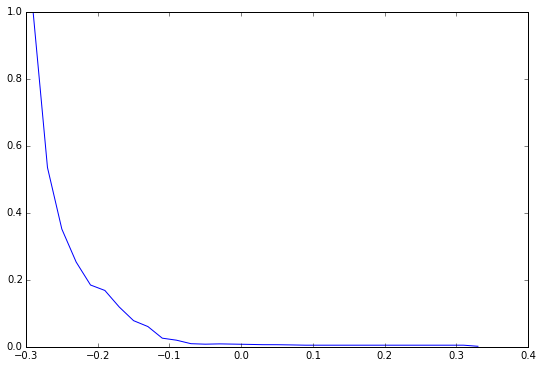

In [14]:
# TODO: conveniences to make this prettier: perhaps actually make wham_hist into a histogram object
wham_hist_list = [ (k, wham_hist[k]) for k in sorted(wham_hist.keys()) ]
plt.plot(list(zip(*wham_hist_list)[0]), list(zip(*wham_hist_list)[1]))

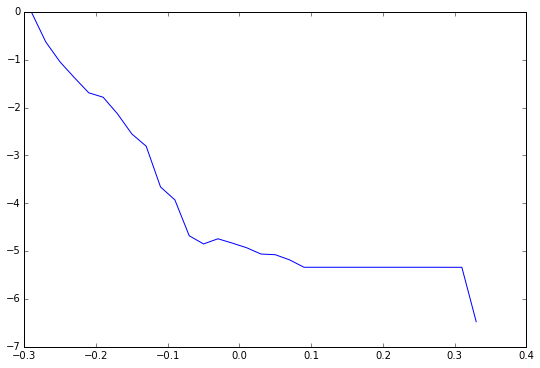

In [15]:
plt.plot(list(zip(*wham_hist_list)[0]), np.log(list(zip(*wham_hist_list)[1])))